In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-edab005d-28f6-d010-fe86-8569da3d3cce)
GPU 1: Tesla T4 (UUID: GPU-740d1f43-2efa-78e4-09c4-8f489e03af5a)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading the Dataset

In [4]:
train_dir = "/kaggle/input/skimlit/RCT-200k Dataset/train.txt"
valid_dir = "/kaggle/input/skimlit/RCT-200k Dataset/dev.txt"
test_dir = "/kaggle/input/skimlit/RCT-200k Dataset/test.txt"

In [5]:
def get_lines(directory):
    with open(directory,"r") as f:
        return f.readlines()

In [6]:
train_lines = get_lines(train_dir)
train_lines[:10]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

In [7]:
valid_lines = get_lines(valid_dir)
valid_lines[:10]

['###15337700\n',
 'BACKGROUND\tAdrenergic activation is thought to be an important determinant of outcome in subjects with chronic heart failure ( CHF ) , but baseline or serial changes in adrenergic activity have not been previously investigated in a large patient sample treated with a powerful antiadrenergic agent .\n',
 'RESULTS\tSystemic venous norepinephrine was measured at baseline , @ months , and @ months in the beta-Blocker Evaluation of Survival Trial ( BEST ) , which compared placebo treatment with the beta-blocker/sympatholytic agent bucindolol .\n',
 'RESULTS\tBaseline norepinephrine level was associated with a progressive increase in rates of death or death plus CHF hospitalization that was independent of treatment group .\n',
 'RESULTS\tOn multivariate analysis , baseline norepinephrine was also a highly significant ( P < @ ) independent predictor of death .\n',
 'RESULTS\tIn contrast , the relation of the change in norepinephrine at @ months to subsequent clinical outc

In [8]:
test_lines = get_lines(test_dir)
test_lines[:10]

['###24562799\n',
 'BACKGROUND\tMany pathogenic processes and diseases are the result of an erroneous activation of the complement cascade and a number of inhibitors of complement have thus been examined for anti-inflammatory actions .\n',
 'BACKGROUND\tIt was recently demonstrated that supraphysiological concentrations of the endogenous complement inhibitor MAp@ ( also denoted MAP@ ) protect against myocardial reperfusion injury .\n',
 'BACKGROUND\tIn the present study , we examined the association between outcome after acute myocardial infarction ( MI ) and the plasma levels of MAp@ and its related proteins MASP-@ and MASP-@ in patients with first-time MI .\n',
 'BACKGROUND\tIn addition , we compared plasma levels of MAp@ , MASP-@ , and MASP-@ in MI patients to levels in a healthy control group .\n',
 'METHODS\tA total of @ MI patients and @ control persons were included .\n',
 'METHODS\tPlasma samples were obtained and analysed with time-resolved immunofluorometric assays determinin

In [9]:
print(f"Number of training lines: {len(train_lines)}")
print(f"Number of validation lines: {len(valid_lines)}")
print(f"Number of testing lines: {len(test_lines)}")

Number of training lines: 2593169
Number of validation lines: 33932
Number of testing lines: 34493


In [10]:
train_lines[:5]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n"]

## Pre-processing the data

In [11]:
sentence = train_lines[1]
sentence

'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n'

In [12]:
target,text = sentence.split("\t")
target, text

('BACKGROUND',
 'The emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n')

In [13]:
def preprocess_data(filename):
    data_list = get_lines(filename)
    
    sentences_list = []
    count=0
    for sentence in data_list:
        if sentence.startswith("###") and count!=0:
            count=0;
        if "\t" in sentence:
            target,text = sentence.split("\t",1)
            dict = {
                "target":target,
                "text":text.strip(),
                "line_number":count,
            }
            sentences_list.append(dict)
            count=count+1
    
    #For adding total_lines in the dictionary
    # Initialize variables
    abstract_start = 0
    total_lines = 0

    # Iterate through the list to add 'total_lines' to each abstract
    for i, sentence_dict in enumerate(sentences_list):
        # Check if it's the start of a new abstract
        if sentence_dict['line_number'] == 0:
            # Add 'total_lines' to dictionaries within the previous abstract
            for j in range(abstract_start, i):
                sentences_list[j]['total_lines'] = total_lines
        
            # Reset variables for the new abstract
            abstract_start = i
            total_lines = 0
    
        total_lines += 1

    # Add 'total_lines' for the last abstract in the list
    for j in range(abstract_start, len(sentences_list)):
        sentences_list[j]['total_lines'] = total_lines

    return sentences_list


In [14]:
train_dict = preprocess_data(train_dir)
train_dict[:5]

[{'target': 'BACKGROUND',
  'text': 'The emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'BACKGROUND',
  'text': 'This paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'This study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': "The intervention group will participate in the online group program ` Positive Outlook ' .",
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  '

In [15]:
valid_dict = preprocess_data(valid_dir)
valid_dict[:5]

[{'target': 'BACKGROUND',
  'text': 'Adrenergic activation is thought to be an important determinant of outcome in subjects with chronic heart failure ( CHF ) , but baseline or serial changes in adrenergic activity have not been previously investigated in a large patient sample treated with a powerful antiadrenergic agent .',
  'line_number': 0,
  'total_lines': 9},
 {'target': 'RESULTS',
  'text': 'Systemic venous norepinephrine was measured at baseline , @ months , and @ months in the beta-Blocker Evaluation of Survival Trial ( BEST ) , which compared placebo treatment with the beta-blocker/sympatholytic agent bucindolol .',
  'line_number': 1,
  'total_lines': 9},
 {'target': 'RESULTS',
  'text': 'Baseline norepinephrine level was associated with a progressive increase in rates of death or death plus CHF hospitalization that was independent of treatment group .',
  'line_number': 2,
  'total_lines': 9},
 {'target': 'RESULTS',
  'text': 'On multivariate analysis , baseline norepineph

In [16]:
test_dict = preprocess_data(test_dir)
test_dict[:5]

[{'target': 'BACKGROUND',
  'text': 'Many pathogenic processes and diseases are the result of an erroneous activation of the complement cascade and a number of inhibitors of complement have thus been examined for anti-inflammatory actions .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'BACKGROUND',
  'text': 'It was recently demonstrated that supraphysiological concentrations of the endogenous complement inhibitor MAp@ ( also denoted MAP@ ) protect against myocardial reperfusion injury .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'BACKGROUND',
  'text': 'In the present study , we examined the association between outcome after acute myocardial infarction ( MI ) and the plasma levels of MAp@ and its related proteins MASP-@ and MASP-@ in patients with first-time MI .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'BACKGROUND',
  'text': 'In addition , we compared plasma levels of MAp@ , MASP-@ , and MASP-@ in MI patients to levels in a healthy control grou

In [17]:
train_df = pd.DataFrame(train_dict)
valid_df = pd.DataFrame(valid_dict)
test_df = pd.DataFrame(test_dict)

In [18]:
train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,The emergence of HIV as a chronic condition me...,0,11
1,BACKGROUND,This paper describes the design and evaluation...,1,11
2,METHODS,This study is designed as a randomised control...,2,11
3,METHODS,The intervention group will participate in the...,3,11
4,METHODS,The program is based on self-efficacy theory a...,4,11


In [19]:
valid_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,Adrenergic activation is thought to be an impo...,0,9
1,RESULTS,Systemic venous norepinephrine was measured at...,1,9
2,RESULTS,Baseline norepinephrine level was associated w...,2,9
3,RESULTS,"On multivariate analysis , baseline norepineph...",3,9
4,RESULTS,"In contrast , the relation of the change in no...",4,9


In [20]:
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,Many pathogenic processes and diseases are the...,0,11
1,BACKGROUND,It was recently demonstrated that supraphysiol...,1,11
2,BACKGROUND,"In the present study , we examined the associa...",2,11
3,BACKGROUND,"In addition , we compared plasma levels of MAp...",3,11
4,METHODS,A total of @ MI patients and @ control persons...,4,11


In [21]:
train_df["target"].value_counts()

target
RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: count, dtype: int64

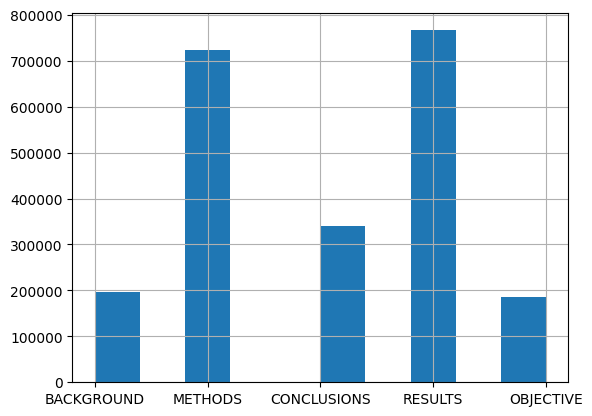

In [22]:
train_df["target"].hist();

In [23]:
train_df["total_lines"].value_counts()

total_lines
11    304733
12    303648
13    266682
10    259640
14    212296
9     183168
15    156015
16    111712
8     110240
17     74987
7      53088
18     48672
19     31502
20     22100
6      21174
21     13797
22      9988
5       6385
23      5750
24      3984
25      2750
26      1924
27      1485
28      1148
4       1148
29       870
30       720
34       442
32       416
31       279
33       264
36       180
35       140
38       114
37       111
51        51
50        50
47        47
46        46
44        44
41        41
3         30
Name: count, dtype: int64

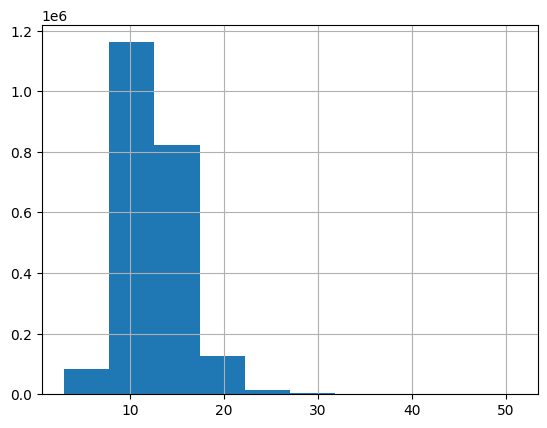

In [24]:
train_df["total_lines"].hist();

In [25]:
train_sentences = train_df["text"].to_numpy()
valid_sentences = valid_df["text"].to_numpy()
test_sentences = test_df["text"].to_numpy()

In [26]:
train_sentences[0]

'The emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .'

In [27]:
valid_sentences[0]

'Adrenergic activation is thought to be an important determinant of outcome in subjects with chronic heart failure ( CHF ) , but baseline or serial changes in adrenergic activity have not been previously investigated in a large patient sample treated with a powerful antiadrenergic agent .'

In [28]:
test_sentences[0]

'Many pathogenic processes and diseases are the result of an erroneous activation of the complement cascade and a number of inhibitors of complement have thus been examined for anti-inflammatory actions .'

In [29]:
len(train_sentences), len(valid_sentences), len(test_sentences)

(2211861, 28932, 29493)

## Converting the Labels into numbers

In [30]:
# One Hot encoding
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
valid_labels_one_hot = one_hot.transform(valid_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot.transform(test_df["target"].to_numpy().reshape(-1,1))

In [31]:
train_labels_one_hot[:5]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [32]:
valid_labels_one_hot[:5]

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [33]:
test_labels_one_hot[:5]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [34]:
# Label Encoding 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"])
valid_labels_encoded = label_encoder.transform(valid_df["target"])
test_labels_encoded = label_encoder.transform(test_df["target"])

In [35]:
train_labels_encoded[:10]

array([0, 0, 2, 2, 2, 2, 2, 2, 2, 1])

In [36]:
valid_labels_encoded[:10]

array([0, 4, 4, 4, 4, 4, 4, 4, 1, 3])

In [37]:
test_labels_encoded[:10]

array([0, 0, 0, 0, 2, 2, 2, 4, 4, 4])

In [38]:
len(train_labels_encoded), len(valid_labels_encoded), len(test_labels_encoded)

(2211861, 28932, 29493)

In [39]:
len(train_labels_one_hot), len(valid_labels_one_hot), len(test_labels_one_hot)

(2211861, 28932, 29493)

In [40]:
train_labels_encoded.shape, train_labels_one_hot.shape

((2211861,), (2211861, 5))

In [41]:
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [42]:
# Helper function to evaluate the models
from sklearn.metrics import accuracy_score, precision_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, recall_score
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true,y_pred)
    precision = precision_score(y_true,y_pred,average="macro")
    recall = recall_score(y_true,y_pred,average="macro")
    f1 = f1_score(y_true,y_pred,average="macro")
    
    results = {
        "Accuracy" : accuracy*100,
        "Precision" : precision*100,
        "Recall" : recall*100,
        "F1" : f1*100
    }    
    return results
    

## Model 0 - Naive Bayes with TF-IDF

In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("Naive-Bayes",MultinomialNB())
])

In [44]:
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()),
                ('Naive-Bayes', MultinomialNB())])

In [45]:
model_0_pred = model_0.predict(valid_sentences)
model_0_pred

array([0, 4, 4, ..., 4, 4, 1])

In [46]:
model_0_results = evaluate_model(valid_labels_encoded,model_0_pred)
model_0_results

{'Accuracy': 74.97580533665146,
 'Precision': 71.34207274186407,
 'Recall': 63.606051767245766,
 'F1': 65.95220846821199}

## Text Vectorization and Embedding

In [47]:
train_sentences[:10]

array(['The emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
       'This paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .',
       'This study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .',
       "The intervention group will participate in the online group program ` Positive Outlook ' .",
       'The program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .',
       'Participants will access the program for a minimum of @ minutes per week over seven weeks 

In [48]:
# Vocabulary size - Number of unique words in the vocabulary
vocab_length = 331000 #According to the research paper

In [49]:
train_sentences[0].split(" ")

['The',
 'emergence',
 'of',
 'HIV',
 'as',
 'a',
 'chronic',
 'condition',
 'means',
 'that',
 'people',
 'living',
 'with',
 'HIV',
 'are',
 'required',
 'to',
 'take',
 'more',
 'responsibility',
 'for',
 'the',
 'self-management',
 'of',
 'their',
 'condition',
 ',',
 'including',
 'making',
 'physical',
 ',',
 'emotional',
 'and',
 'social',
 'adjustments',
 '.']

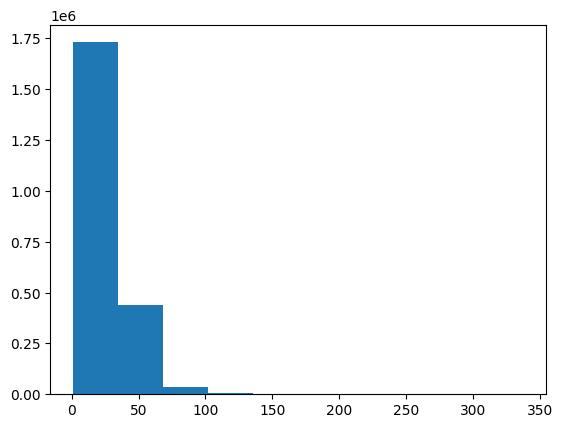

In [50]:
sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
plt.hist(sentence_lengths);

In [51]:
output_sequence_length = int(np.percentile(sentence_lengths,95))
output_sequence_length

54

In [52]:
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens = vocab_length,
                                   output_mode="int",
                                    output_sequence_length = output_sequence_length
                                   )

In [53]:
from tensorflow.keras.layers import Embedding
embedding = Embedding(input_dim = vocab_length,
                     input_length = output_sequence_length,
                     output_dim = 128)

In [54]:
text_vectorizer.adapt(train_sentences)

In [55]:
import random
random_sentence = random.choice(train_sentences)
print(f"Original sentence: \n{random_sentence}")
print(f"\nLength of original sentence: {len(random_sentence.split())}")
print(f"\nVectorised sentence: \n{text_vectorizer([random_sentence])}")
print(f"\nShape of vectorised sentence: {(text_vectorizer([random_sentence]).shape)}")
print(f"\nEmbedded sentence: \n{embedding(text_vectorizer([random_sentence]))}")
print(f"Shape of embedded sentence: {embedding(text_vectorizer([random_sentence])).shape}")

Original sentence: 
The evaluation of the patients was performed by history details , clinical examination findings , measurement of the joint laxity by KT-@ arthrometer , and use of validated patient outcome questionnaires .

Length of original sentence: 32

Vectorised sentence: 
[[    2   389     3     2    11    10   143    21   681  6344    48   643
    346   846     3     2  1074  8298    21  6137 16540     4    84     3
   1529   112   104  1046     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]]

Shape of vectorised sentence: (1, 54)

Embedded sentence: 
[[[-0.0067479  -0.00056176 -0.01965795 ...  0.02820272  0.02631091
    0.03805878]
  [ 0.0101998   0.02803176  0.0363577  ... -0.01562975 -0.03660557
   -0.0051409 ]
  [ 0.02967973 -0.00293739  0.03739519 ...  0.01716241 -0.04012502
    0.01684797]
  ...
  [-0.04261653  0.01029376 -0.04427132 ... -0.01142688 -0.00894543


In [56]:
words_in_vocab = text_vectorizer.get_vocabulary()
print(f"5 most common words in vocabulary: {words_in_vocab[:5]}")
print(f"5 least common words in vocabulary: {words_in_vocab[-5:] }")

5 most common words in vocabulary: ['', '[UNK]', 'the', 'of', 'and']
5 least common words in vocabulary: ['aaae', 'aaacp', 'aaabbb', 'aaaanalog', 'aaaa']


In [57]:
len(words_in_vocab)

247961

In [58]:
# Getting the config of text vectorization and embedding
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 331000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 54,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 247961}

In [59]:
embedding.get_config()

{'name': 'embedding',
 'trainable': True,
 'dtype': 'float32',
 'batch_input_shape': (None, 54),
 'input_dim': 331000,
 'output_dim': 128,
 'embeddings_initializer': {'module': 'keras.initializers',
  'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None},
  'registered_name': None},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': 54}

## Creating a fast loading dataset using tf.data API

In [60]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_sentences,valid_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [61]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1 - Conv1D trained on tf.Dataset

In [62]:
from tensorflow.keras import layers
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = embedding(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(5, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
     

In [63]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 54)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 54, 128)           42368000  
                                                                 
 conv1d (Conv1D)             (None, 54, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 5)                 325   

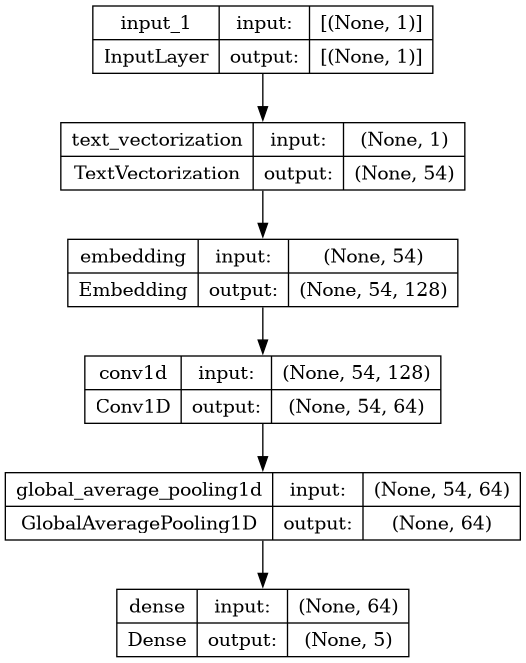

In [64]:
from tensorflow.keras.utils import plot_model
plot_model(model_1,show_shapes=True)

In [65]:
history_model_1 = model_1.fit(train_dataset,
                             validation_data = valid_dataset,
                             epochs=3,
                             steps_per_epoch = int(0.1*len(train_dataset)),
                             validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
6912/6912 [==============================] - 133s 19ms/step - loss: 0.5890 - accuracy: 0.7895 - val_loss: 0.5055 - val_accuracy: 0.8174
Epoch 2/3
6912/6912 [==============================] - 92s 13ms/step - loss: 0.5019 - accuracy: 0.8227 - val_loss: 0.4720 - val_accuracy: 0.8323
Epoch 3/3
6912/6912 [==============================] - 90s 13ms/step - loss: 0.4809 - accuracy: 0.8300 - val_loss: 0.4554 - val_accuracy: 0.8316


<Axes: >

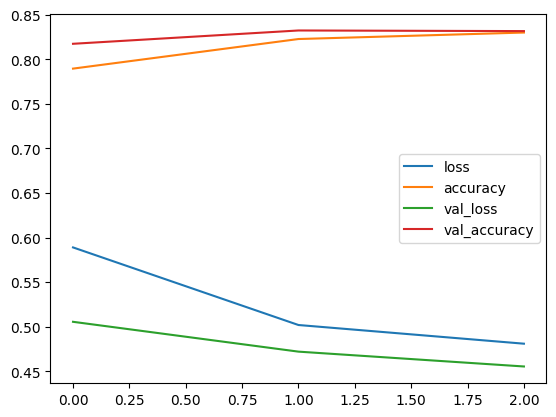

In [66]:
pd.DataFrame(history_model_1.history).plot()

In [67]:
model_1_pred = model_1.predict(valid_dataset)

905/905 [==============================] - 2s 2ms/step


In [68]:
model_1_pred

array([[9.0766656e-01, 1.4287478e-03, 3.9081960e-06, 9.0898208e-02,
        2.6127148e-06],
       [2.6092531e-02, 1.0959189e-02, 8.2137078e-01, 2.0266933e-02,
        1.2131055e-01],
       [1.8660664e-03, 1.3504104e-01, 4.8540225e-03, 4.4361633e-04,
        8.5779524e-01],
       ...,
       [6.4856233e-04, 4.2877364e-01, 1.3837393e-04, 1.4904838e-04,
        5.7029039e-01],
       [1.4408031e-02, 3.5525003e-01, 3.7572619e-03, 5.0871302e-03,
        6.2149751e-01],
       [1.9092476e-01, 7.1239024e-01, 3.3761507e-03, 8.6276054e-02,
        7.0327320e-03]], dtype=float32)

In [69]:
model_1_pred = np.argmax(model_1_pred,axis=1)
model_1_pred

array([0, 2, 4, ..., 4, 4, 1])

In [70]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [71]:
model_1_results = evaluate_model(valid_labels_encoded, model_1_pred)
model_1_results

{'Accuracy': 83.72044794691,
 'Precision': 79.92730228181216,
 'Recall': 76.60612277142171,
 'F1': 77.49627210130386}

## Model 2 - Universal Sentence Encoder

In [72]:
import tensorflow_hub as hub
tf_hub_embedding = hub.KerasLayer("/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2",
                                 trainable=False,
                                 name="universal_sentence_encoder")

In [73]:
random_sentence = random.choice(train_sentences)
print(f"Random sentence: \n{random_sentence}")
print(f"\nEmbedded sentence using USE : \n{tf_hub_embedding([random_sentence])}")
print(f"\nShape of the embedded sentence: {tf_hub_embedding([random_sentence]).shape}.")

Random sentence: 
Nonrevascularized lesions originally @ % DS were more often index lesions in OMT-only patients , but still represented a minority ( < @ % ) of all such lesions .

Embedded sentence using USE : 
[[-0.07560055  0.05310005  0.01417676  0.00616585  0.01961211  0.03314354
  -0.06117835  0.00490401  0.00728128  0.04245848  0.08359604  0.04065391
  -0.05780667  0.0628251   0.02187816 -0.02997771 -0.08372464 -0.07401094
   0.02829291 -0.00802897 -0.05721271  0.05689137 -0.04436101 -0.04700316
   0.06661692 -0.00454512  0.00713345 -0.06714052  0.00249913  0.01509903
  -0.05826349  0.08423734  0.05180319 -0.06172598 -0.073712    0.02781134
  -0.0443621   0.07428439  0.0288628  -0.03857109 -0.06281891  0.02732575
   0.01583348  0.00140732  0.03881597  0.07964727  0.05576196 -0.03652505
  -0.04756771 -0.00783343 -0.00654322 -0.02015089 -0.02908431 -0.06445347
   0.05104127  0.00238316 -0.05096815 -0.04932607  0.05366274 -0.02843901
  -0.05642539 -0.00076198  0.06485121  0.0150362

In [74]:
from tensorflow.keras import layers
inputs = layers.Input(shape=[],dtype="string")
x = tf_hub_embedding(inputs)
x= layers.Dense(128,activation="relu")(x)
outputs = layers.Dense(5,activation="softmax")(x)

model_2 = tf.keras.Model(inputs,outputs)

model_2.compile(loss="categorical_crossentropy",
               optimizer= tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [75]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


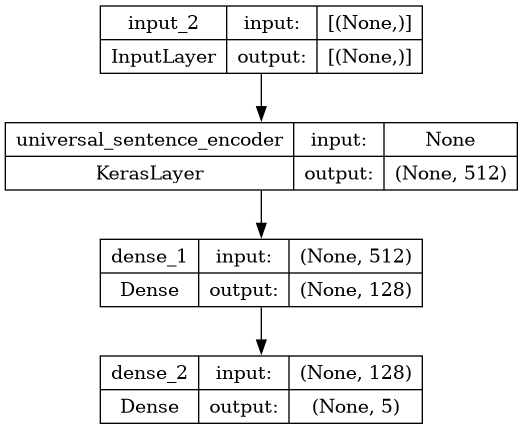

In [76]:
plot_model(model_2,show_shapes=True)

In [77]:
history_model_2 = model_2.fit(train_dataset,
                             epochs=3,
                             validation_data=valid_dataset,
                             steps_per_epoch=int(0.1*len(train_dataset)),
                             validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
6912/6912 [==============================] - 68s 9ms/step - loss: 0.6972 - accuracy: 0.7345 - val_loss: 0.6317 - val_accuracy: 0.7573
Epoch 2/3
6912/6912 [==============================] - 64s 9ms/step - loss: 0.6241 - accuracy: 0.7641 - val_loss: 0.6010 - val_accuracy: 0.7663
Epoch 3/3
6912/6912 [==============================] - 64s 9ms/step - loss: 0.6015 - accuracy: 0.7736 - val_loss: 0.5841 - val_accuracy: 0.7733


In [78]:
model_2_pred = model_2.predict(valid_dataset)

905/905 [==============================] - 7s 8ms/step


In [79]:
model_2_pred = np.argmax(model_2_pred,axis=1)
model_2_pred

array([1, 2, 4, ..., 1, 4, 1])

In [80]:
model_2_results = evaluate_model(valid_labels_encoded, model_2_pred)
model_2_results

{'Accuracy': 77.51970136872667,
 'Precision': 71.933437275504,
 'Recall': 69.45607046956759,
 'F1': 70.43117974775731}

## Model 3 - Conv1D with character level embedding

In [81]:
# This will create a list of characters present in the sentence
sample_sentence = list(train_sentences[0])
sample_sentence[:10]

['T', 'h', 'e', ' ', 'e', 'm', 'e', 'r', 'g', 'e']

In [82]:
" ".join(sample_sentence)

'T h e   e m e r g e n c e   o f   H I V   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   H I V   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .'

In [83]:
random_sentence = random.choice(train_sentences)
print(f"Before: \n{random_sentence}")
print(f"\nAfter: \n{' '.join(list(random_sentence))}")

Before: 
However , by @ h postmeal , plasma glucose levels were significantly higher with nateglinide ( @ + / - @ mmol/l ) compared with the premeal baseline ( @ + / - @ mmol/l , P = @ ) and compared with the @-h postprandial glucose level after administration of glipizide ( @ + / - @ mmol/l , P = @ ) .

After: 
H o w e v e r   ,   b y   @   h   p o s t m e a l   ,   p l a s m a   g l u c o s e   l e v e l s   w e r e   s i g n i f i c a n t l y   h i g h e r   w i t h   n a t e g l i n i d e   (   @   +   /   -   @   m m o l / l   )   c o m p a r e d   w i t h   t h e   p r e m e a l   b a s e l i n e   (   @   +   /   -   @   m m o l / l   ,   P   =   @   )   a n d   c o m p a r e d   w i t h   t h e   @ - h   p o s t p r a n d i a l   g l u c o s e   l e v e l   a f t e r   a d m i n i s t r a t i o n   o f   g l i p i z i d e   (   @   +   /   -   @   m m o l / l   ,   P   =   @   )   .


In [84]:
# Transforming our data for char level embedding
def split_chars(text):
    return " ".join(list(text))

In [85]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
valid_chars = [split_chars(sentence) for sentence in valid_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [86]:
train_chars[0]

'T h e   e m e r g e n c e   o f   H I V   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   H I V   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .'

In [87]:
valid_chars[0]

'A d r e n e r g i c   a c t i v a t i o n   i s   t h o u g h t   t o   b e   a n   i m p o r t a n t   d e t e r m i n a n t   o f   o u t c o m e   i n   s u b j e c t s   w i t h   c h r o n i c   h e a r t   f a i l u r e   (   C H F   )   ,   b u t   b a s e l i n e   o r   s e r i a l   c h a n g e s   i n   a d r e n e r g i c   a c t i v i t y   h a v e   n o t   b e e n   p r e v i o u s l y   i n v e s t i g a t e d   i n   a   l a r g e   p a t i e n t   s a m p l e   t r e a t e d   w i t h   a   p o w e r f u l   a n t i a d r e n e r g i c   a g e n t   .'

In [88]:
test_chars[0]

'M a n y   p a t h o g e n i c   p r o c e s s e s   a n d   d i s e a s e s   a r e   t h e   r e s u l t   o f   a n   e r r o n e o u s   a c t i v a t i o n   o f   t h e   c o m p l e m e n t   c a s c a d e   a n d   a   n u m b e r   o f   i n h i b i t o r s   o f   c o m p l e m e n t   h a v e   t h u s   b e e n   e x a m i n e d   f o r   a n t i - i n f l a m m a t o r y   a c t i o n s   .'

In [89]:
char_lengths = [len(sentence) for sentence in train_sentences]
char_lengths[:5]

[226, 160, 176, 90, 195]

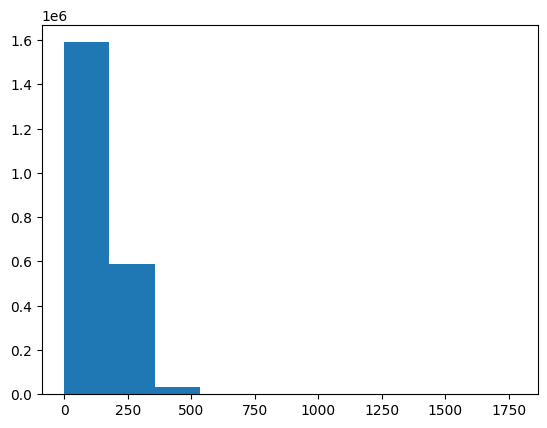

In [90]:
plt.hist(char_lengths);

In [91]:
output_char_length = int(np.percentile(char_lengths, 95))
output_char_length

284

In [92]:
# Getting all the unique characters
# The number of unique characters are not only 26, because the sentences consist of many other chars like @, , ,=
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation 
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [93]:
char_vocab_length = len(alphabet) + 2
char_vocab_length

70

In [94]:
# Setting up the character vectorizer
char_vectorizer = TextVectorization(max_tokens = char_vocab_length,
                                output_sequence_length = output_char_length)

### Fitting/Adapting the character vectorizer in parts, to avoid exhaustion of RAM

In [95]:
char_vectorizer.adapt(train_chars[:50000])

In [96]:
char_vectorizer.adapt(train_chars[50000:100000])

In [97]:
char_vectorizer.adapt(train_chars[100000:500000])

In [98]:
char_vectorizer.adapt(train_chars[500000:1000000])

In [99]:
char_vectorizer.adapt(train_chars[1000000:1500000])

In [100]:
char_vectorizer.adapt(train_chars[1500000:2000000])

In [101]:
char_vectorizer.adapt(train_chars[2000000:])

In [102]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")


5 most common characters: ['', '[UNK]', 'e', 't', 'a']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [103]:
char_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 70,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 284,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 28}

In [104]:
random_sentence = random.choice(train_chars)
print(f"Charified text : \n{random_sentence}")
print(f"\nChar vectorised text : \n{char_vectorizer([random_sentence])}")
print(f"\nShape of vectorised text : {(char_vectorizer([random_sentence])).shape}")

Charified text : 
T h e   @   p e r c e n t   c o n f i d e n c e   i n t e r v a l   w a s   @ - @   @   .

Char vectorised text : 
[[ 3 13  2 14  2  8 12  2  6  3 12  7  6 17  5 10  2  6 12  2  5  6  3  2
   8 21  4 11 20  4  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [105]:
char_embedding = Embedding(input_dim = char_vocab_length,
                          input_length=output_char_length,
                          output_dim=25)

In [106]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_sentence}\n")
char_embed_example = char_embedding(char_vectorizer([random_sentence]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")
     

Charified text (before vectorization and embedding):
T h e   @   p e r c e n t   c o n f i d e n c e   i n t e r v a l   w a s   @ - @   @   .

Embedded chars (after vectorization and embedding):
[[[-0.04188608  0.04756044 -0.00309939 ... -0.0461789   0.03876083
   -0.02041065]
  [-0.03524351 -0.01833075 -0.02266299 ...  0.01623005 -0.03071281
   -0.00841191]
  [ 0.02031293 -0.04789931 -0.03804915 ...  0.04157922  0.04471798
   -0.01267514]
  ...
  [-0.04213188  0.0134705  -0.01405365 ...  0.01411133 -0.01934931
    0.03259208]
  [-0.04213188  0.0134705  -0.01405365 ...  0.01411133 -0.01934931
    0.03259208]
  [-0.04213188  0.0134705  -0.01405365 ...  0.01411133 -0.01934931
    0.03259208]]]

Character embedding shape: (1, 284, 25)


### Creating character level datasets using tf.data API

In [107]:
# creating char level datasets
train_chars_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_chars_dataset = tf.data.Dataset.from_tensor_slices((valid_chars,valid_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_datast = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [108]:
inputs = layers.Input(shape=(1),dtype="string")
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(64,activation="relu",kernel_size=5,padding="same")(x)
x = layers.GlobalMaxPool1D()(x)
outputs= layers.Dense(5,activation="softmax")(x)

model_3 = tf.keras.Model(inputs,outputs)

In [109]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 284)               0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 284, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 284, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [110]:
model_3.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [111]:
history_model_3 = model_3.fit(train_chars_dataset,
                             validation_data = valid_chars_dataset ,
                             epochs=3,
                              steps_per_epoch = int(0.1*len(train_chars_dataset)),
                              validation_steps = int(0.1*len(valid_chars_dataset))
                             )

Epoch 1/3
6912/6912 [==============================] - 32s 4ms/step - loss: 0.8604 - accuracy: 0.6680 - val_loss: 0.7425 - val_accuracy: 0.7191
Epoch 2/3
6912/6912 [==============================] - 30s 4ms/step - loss: 0.7278 - accuracy: 0.7261 - val_loss: 0.7214 - val_accuracy: 0.7344
Epoch 3/3
6912/6912 [==============================] - 30s 4ms/step - loss: 0.7022 - accuracy: 0.7373 - val_loss: 0.6701 - val_accuracy: 0.7549


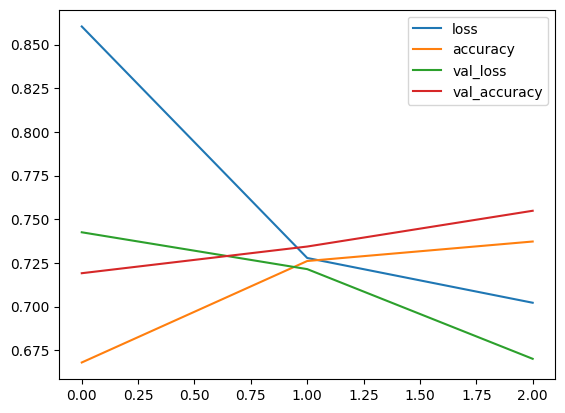

In [112]:
pd.DataFrame(history_model_3.history).plot();

In [113]:
model_3_pred = model_3.predict(valid_chars_dataset)

905/905 [==============================] - 2s 2ms/step


In [114]:
model_3_pred = np.argmax(model_3_pred,axis=1)
model_3_pred

array([1, 2, 4, ..., 1, 1, 1])

In [115]:
model_3_results = evaluate_model(valid_labels_encoded,model_3_pred)
model_3_results

{'Accuracy': 74.98271809760818,
 'Precision': 69.20777485490912,
 'Recall': 64.88520080411207,
 'F1': 66.37241322746902}

## Model 4 - Token embeddings + Char embeddings

In [116]:
# token embedding model
token_inputs = layers.Input(shape=[],dtype="string",name="token_input")
embed_layer = tf_hub_embedding(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(embed_layer)
token_model = tf.keras.Model(inputs = token_inputs, outputs=token_outputs)

# character embedding model
char_inputs = layers.Input(shape=(1,),dtype="string",name="char_input")
char_vect = char_vectorizer(char_inputs)
char_embed = char_embedding(char_vect)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embed)
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_bi_lstm)

# concatenating 
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,char_model.output])

# output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5,activation="softmax")(final_dropout)

# combined model
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],outputs = output_layer,name="model_4_hybrid")

In [117]:
model_4.summary()

Model: "model_4_hybrid"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 284)                  0         ['char_input[0][0]']          
 Vectorization)                                                                                   
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0][

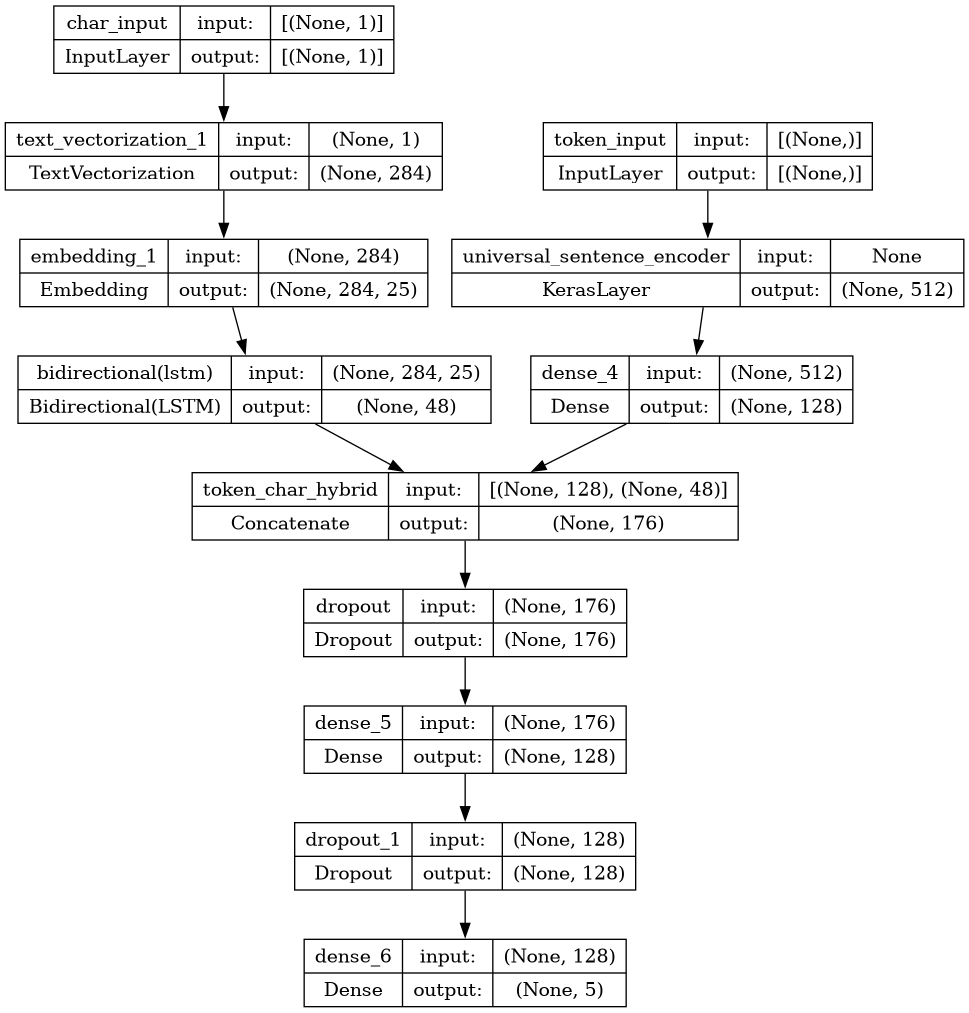

In [118]:
plot_model(model_4,show_shapes=True)

In [119]:
model_4.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

### Creating combined dataset of sentences and characters

In [120]:
train_sentences[:1], train_chars[:1]

(array(['The emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .'],
       dtype=object),
 ['T h e   e m e r g e n c e   o f   H I V   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   H I V   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .'])

In [121]:
train_hybrid_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_hybrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_hybrid_dataset = tf.data.Dataset.zip((train_hybrid_data,train_hybrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [122]:
valid_hybrid_data = tf.data.Dataset.from_tensor_slices((valid_sentences,valid_chars))
valid_hybrid_labels = tf.data.Dataset.from_tensor_slices(valid_labels_one_hot)

valid_hybrid_dataset = tf.data.Dataset.zip((valid_hybrid_data,valid_hybrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [123]:
test_hybrid_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_hybrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_hybrid_dataset = tf.data.Dataset.zip((test_hybrid_data,test_hybrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [124]:
history_model_4 = model_4.fit(train_hybrid_dataset,
                             epochs=3,
                             validation_data =valid_hybrid_dataset,
                             steps_per_epoch = int(0.1*len(train_hybrid_dataset)),
                             validation_steps = int(0.1*len(valid_hybrid_dataset)))

Epoch 1/3
6912/6912 [==============================] - 158s 22ms/step - loss: 0.7271 - accuracy: 0.7259 - val_loss: 0.6105 - val_accuracy: 0.7642
Epoch 2/3
6912/6912 [==============================] - 151s 22ms/step - loss: 0.6615 - accuracy: 0.7535 - val_loss: 0.5791 - val_accuracy: 0.7760
Epoch 3/3
6912/6912 [==============================] - 154s 22ms/step - loss: 0.6424 - accuracy: 0.7613 - val_loss: 0.5582 - val_accuracy: 0.7792


<Axes: >

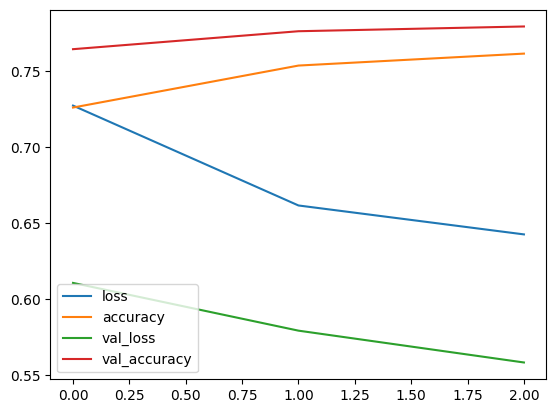

In [125]:
pd.DataFrame(history_model_4.history).plot()

In [126]:
model_4_preds = model_4.predict(valid_hybrid_dataset)

905/905 [==============================] - 12s 12ms/step


In [127]:
model_4_preds = np.argmax(model_4_preds,axis=1)
model_4_preds

array([4, 2, 4, ..., 1, 4, 1])

In [128]:
model_4_results = evaluate_model(valid_labels_encoded,model_4_preds)
model_4_results

{'Accuracy': 78.1729572791373,
 'Precision': 73.19996241419807,
 'Recall': 69.92228431501903,
 'F1': 71.25765948749998}

## Model 5 - Pretrained embedding + char embedding + positional embedding

In [129]:
train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,The emergence of HIV as a chronic condition me...,0,11
1,BACKGROUND,This paper describes the design and evaluation...,1,11
2,METHODS,This study is designed as a randomised control...,2,11
3,METHODS,The intervention group will participate in the...,3,11
4,METHODS,The program is based on self-efficacy theory a...,4,11


In [130]:
train_df["line_number"].value_counts()

line_number
0     190654
1     190654
2     190654
3     190644
4     190357
5     189080
6     185551
7     177967
8     164187
9     143835
10    117871
11     90168
12     64864
13     44350
14     29186
15     18785
16     11803
17      7392
18      4688
19      3030
20      1925
21      1268
22       814
23       564
24       398
25       288
26       214
27       159
28       118
29        88
30        64
31        55
32        42
33        34
34        21
35        17
36        12
37         9
40         6
38         6
39         6
41         5
42         5
43         5
44         4
45         4
46         3
47         2
48         2
49         2
50         1
Name: count, dtype: int64

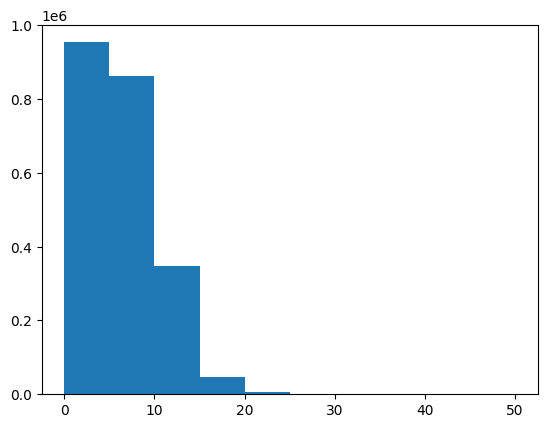

In [131]:
plt.hist(train_df["line_number"]);

In [132]:
# Using tf to create one hot encoded line numbers
train_line_numbers_onehot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
train_line_numbers_onehot[:10], train_line_numbers_onehot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([2211861, 15]))

In [133]:
valid_line_numbers_onehot = tf.one_hot(valid_df["line_number"].to_numpy(),depth=15)
test_line_numbers_onehot = tf.one_hot(test_df["line_number"].to_numpy(),depth=15)


In [134]:
train_df["total_lines"].value_counts()

total_lines
11    304733
12    303648
13    266682
10    259640
14    212296
9     183168
15    156015
16    111712
8     110240
17     74987
7      53088
18     48672
19     31502
20     22100
6      21174
21     13797
22      9988
5       6385
23      5750
24      3984
25      2750
26      1924
27      1485
28      1148
4       1148
29       870
30       720
34       442
32       416
31       279
33       264
36       180
35       140
38       114
37       111
51        51
50        50
47        47
46        46
44        44
41        41
3         30
Name: count, dtype: int64

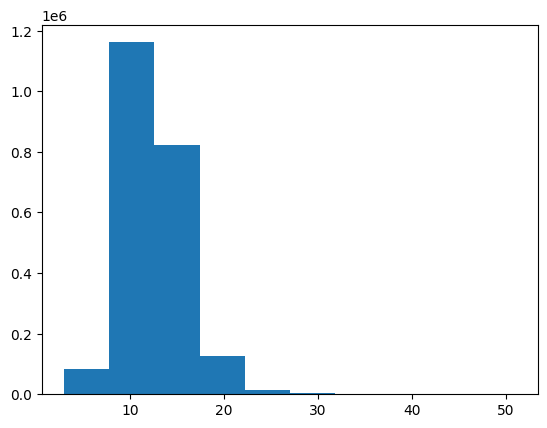

In [135]:
plt.hist(train_df["total_lines"]);

In [136]:
np.percentile(train_df.total_lines, 98)

21.0

In [137]:
train_total_lines_onehot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=21)
train_total_lines_onehot[:5]

<tf.Tensor: shape=(5, 21), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]], dtype=float32)>

In [138]:
valid_total_lines_onehot = tf.one_hot(valid_df["total_lines"].to_numpy(),depth=21)
test_total_lines_onehot = tf.one_hot(test_df["total_lines"].to_numpy(),depth=21)


In [139]:
# 1 token inputs
token_inputs = layers.Input(dtype="string",shape=[],name="token_inputs")
token_embeddings = tf_hub_embedding(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs = token_outputs)

# 2 char inputs
char_inputs = layers.Input(shape=(1, ),dtype="string",name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_bi_lstm)

# 3 Line numbers
line_number_inputs = layers.Input(shape=(15,),dtype=tf.float32,name="line_number_inputs")
line_number_outputs = layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs = line_number_outputs)

# 4. Total lines
total_line_inputs = layers.Input(shape=(21,),dtype=tf.float32,name="total_lines_input")
total_line_outputs = layers.Dense(32,activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(inputs=total_line_inputs,outputs = total_line_outputs)

# 5. Combine token and char embedding into hybrid embedding
combined_embedding = layers.Concatenate(name="hybrid_embedding_model")([token_model.output, char_model.output])

x = layers.Dense(256,activation="relu")(combined_embedding)
x = layers.Dropout(0.5)(x)
 
# 6. Combine positional embeddings with combined_embedding
tribrid_embeddings = layers.Concatenate(name="tribrid_model")([line_number_model.output,
                                                              total_line_model.output,
                                                              x])

# 7. output layer 
output_layer = layers.Dense(5,activation="softmax",name="output_layer")(tribrid_embeddings)

model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                total_line_model.input,
                                token_model.input,
                                char_model.input],
                        outputs=output_layer)

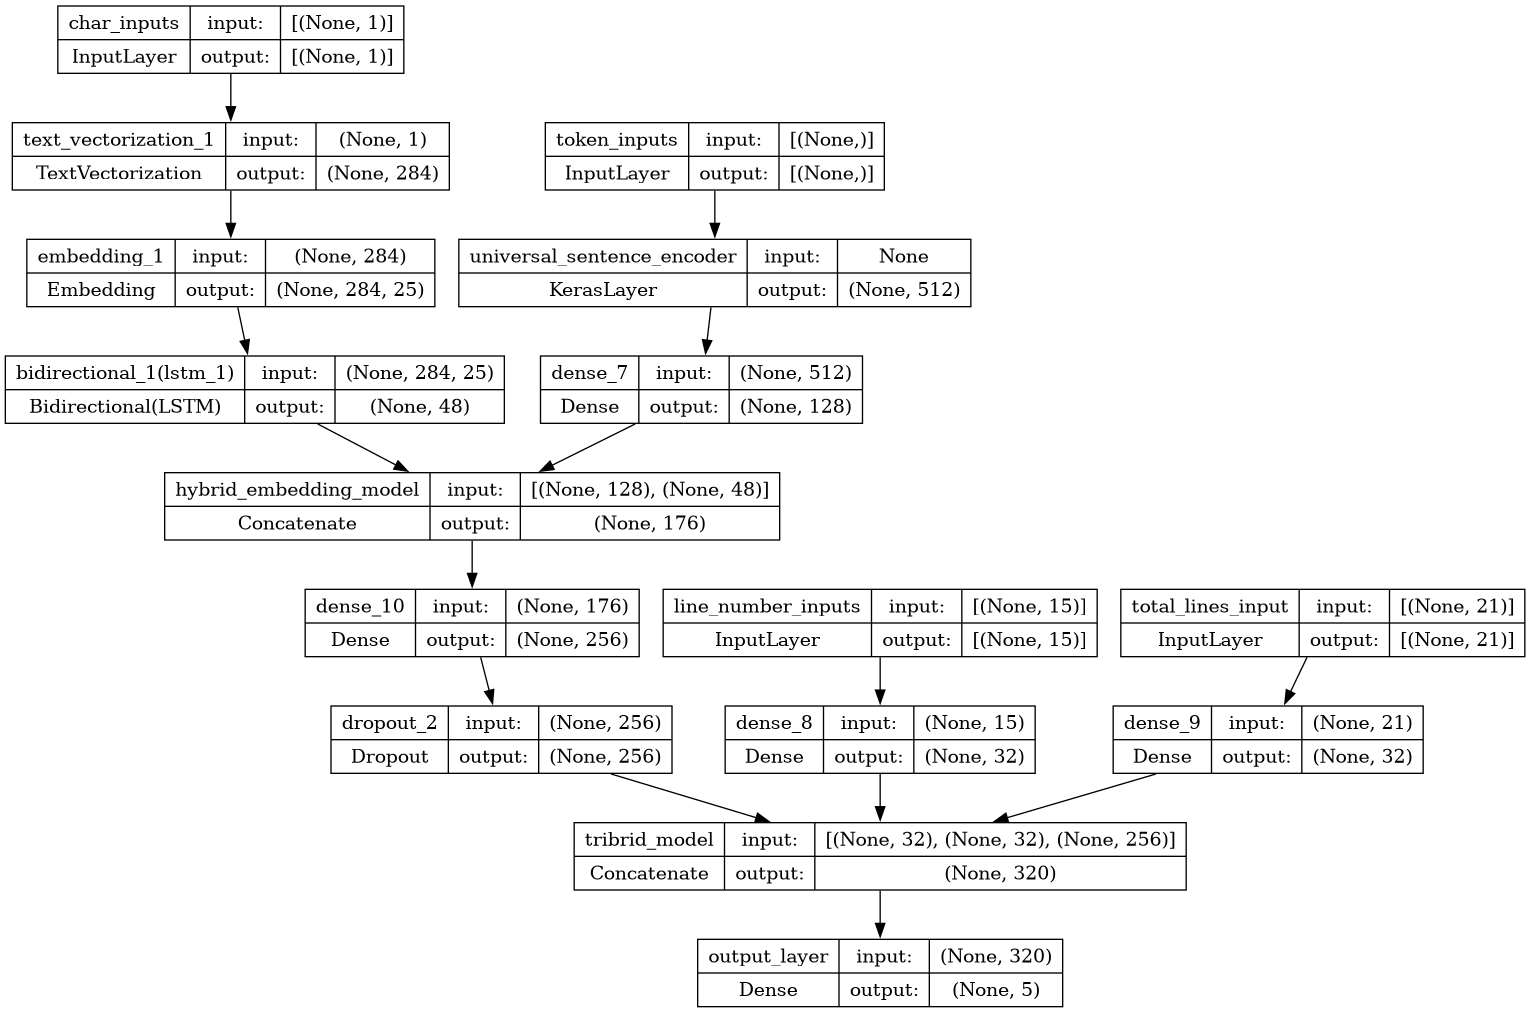

In [140]:
plot_model(model_5,show_shapes=True)

In [141]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [142]:
# Creating the dataset for the model_5 - tribrid model

train_combine = tf.data.Dataset.from_tensor_slices((train_line_numbers_onehot,
                                                      train_total_lines_onehot,
                                                      train_sentences,
                                                      train_chars))
train_combine_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_combine_dataset = tf.data.Dataset.zip((train_combine,train_combine_labels))
train_combine_dataset = train_combine_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [143]:
# Creating the dataset for the model_5 - tribrid model

valid_combine = tf.data.Dataset.from_tensor_slices((valid_line_numbers_onehot,
                                                      valid_total_lines_onehot,
                                                      valid_sentences,
                                                      valid_chars))
valid_combine_labels = tf.data.Dataset.from_tensor_slices(valid_labels_one_hot)

valid_combine_dataset = tf.data.Dataset.zip((valid_combine,valid_combine_labels))
valid_combine_dataset = valid_combine_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [144]:
history_model_5 = model_5.fit(train_combine_dataset,
                             validation_data=valid_combine_dataset,
                             epochs=3,
                             steps_per_epoch=int(0.1*len(train_combine_dataset)),
                             validation_steps = int(0.1*len(valid_combine_dataset)))

Epoch 1/3
6912/6912 [==============================] - 161s 23ms/step - loss: 0.9396 - accuracy: 0.8307 - val_loss: 0.9099 - val_accuracy: 0.8542
Epoch 2/3
6912/6912 [==============================] - 153s 22ms/step - loss: 0.9056 - accuracy: 0.8542 - val_loss: 0.8957 - val_accuracy: 0.8660
Epoch 3/3
6912/6912 [==============================] - 154s 22ms/step - loss: 0.9005 - accuracy: 0.8570 - val_loss: 0.8857 - val_accuracy: 0.8684


In [145]:
model_5_pred = model_5.predict(valid_combine_dataset)

905/905 [==============================] - 12s 12ms/step


In [146]:
model_5_pred = np.argmax(model_5_pred,axis=1)
model_5_pred

array([0, 2, 4, ..., 4, 4, 1])

In [147]:
model_5_results = evaluate_model(valid_labels_encoded,model_5_pred)
model_5_results

{'Accuracy': 86.6687404949537,
 'Precision': 84.09559065569702,
 'Recall': 81.44821369421422,
 'F1': 82.15683724837014}

## Comparing the results of all the models

In [149]:
results = {
    "Model 0":model_0_results,
    "Model 1":model_1_results,
    "Model 2":model_2_results,
    "Model 3":model_3_results,
    "Model 4":model_4_results,
    "Model 5":model_5_results
}

results = pd.DataFrame(results).transpose()
results

,Accuracy,Precision,Recall,F1
Model 0,74.975805,71.342073,63.606052,65.952208
Model 1,83.720448,79.927302,76.606123,77.496272
Model 2,77.519701,71.933437,69.456070,70.431180
Model 3,74.982718,69.207775,64.885201,66.372413
Model 4,78.172957,73.199962,69.922284,71.257659
Model 5,86.668740,84.095591,81.448214,82.156837


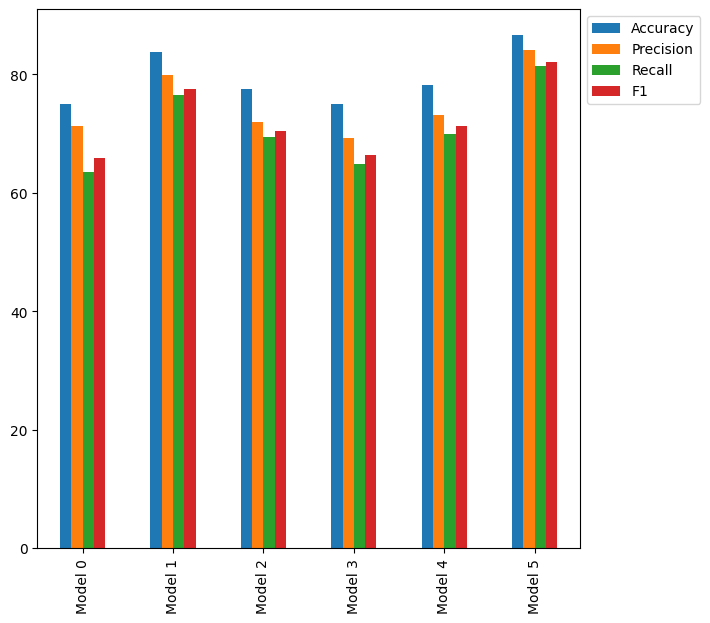

In [150]:
results.plot(kind="bar",figsize=(7,7));
plt.legend(bbox_to_anchor=(1.0,1.0));

In [169]:
from sklearn.metrics import classification_report
print(classification_report(valid_labels_encoded, model_5_pred))

              precision    recall  f1-score   support

           0       0.69      0.82      0.75      2575
           1       0.91      0.85      0.88      4396
           2       0.89      0.93      0.91      9559
           3       0.83      0.57      0.68      2425
           4       0.88      0.90      0.89      9977

    accuracy                           0.87     28932
   macro avg       0.84      0.81      0.82     28932
weighted avg       0.87      0.87      0.87     28932



## Making predictions from the test data

In [151]:
import nltk

In [158]:
def abstract_to_array(text):
    # Tokenize the abstract into sentences
    sentences = nltk.sent_tokenize(text)

    # Convert the list of sentences into a NumPy array
    sentences_array = np.array(sentences, dtype=object)
    
    return sentences_array


In [159]:
def make_predictions(abstract):
    """
    Function to make predictions on an abstract by performing necessary preprocessing and utilizing a pre-trained model.

    Parameters:
    - abstract (str): The input abstract for which predictions are to be made.
    - class_names (list): List of class names representing the categories for predictions.

    Output:
    The function prints the abstract sentences grouped by predicted class labels.
    """

    # Convert the abstract into an array of sentences
    sentences_array = abstract_to_array(abstract)

    # Create a dictionary to store each sentence
    abs_dict = {"text": sentences_array}

    # Convert the dictionary into a DataFrame
    abs_df = pd.DataFrame(abs_dict)

    # Add 'Line number' column into the DataFrame
    abs_df["line_number"] = abs_df.index

    # Add 'Total lines' column into the DataFrame
    abs_df["total_lines"] = abs_df["line_number"][len(abs_df) - 1] + 1

    # Convert the 'line number' column into one-hot encoded array
    abs_line_number = tf.one_hot(abs_df["line_number"].to_numpy(), depth=15)

    # Convert the 'Total lines' column into one-hot encoded array
    abs_total_line = tf.one_hot(abs_df["total_lines"].to_numpy(), depth=21)

    # Character level sentences
    abs_chars = [split_chars(sentence) for sentence in sentences_array]

    # Combine the data and create a tf.data dataset
    abs_data_combined = tf.data.Dataset.from_tensor_slices((abs_line_number,
                                                            abs_total_line,
                                                            sentences_array,
                                                            abs_chars))

    abs_data_combined = abs_data_combined.batch(32).prefetch(tf.data.AUTOTUNE)

    # Map the dataset to match the model inputs
    abs_data_combined = abs_data_combined.map(lambda x1, x2, x3, x4:
                                              ({'line_number_inputs': x1,
                                                'total_lines_input': x2,
                                                'token_inputs': x3,
                                                'char_inputs': x4},))

    # Predict using the modified dataset
    predictions = model_5.predict(abs_data_combined)

    predictions = np.argmax(predictions, axis=1)

    # Display predictions in a more understandable format
    grouped_sentences = {
        "OBJECTIVE": [],
        "BACKGROUND": [],
        "METHODS": [],
        "RESULTS": [],
        "CONCLUSIONS": []
    }

    for i in range(len(abs_df)):
        class_name = class_names[predictions[i]]
        sentence = abs_df["text"][i]

        # Append the sentence to the corresponding label group
        grouped_sentences[class_name].append(sentence)

    for label, sentences in grouped_sentences.items():
        if sentences != []:
            print(f"{label}\n=============")
            for sentence in sentences:
                print(sentence, end=" ")
            print("\n\n")


In [153]:
abstract_1 = '''The purpose of these two studies was to define the optimal therapeutic dose of the 5-HT3 receptor antagonist tropisetron (Navoban, ICS 205-930) in cisplatin-induced nausea and vomiting. In two multicenter, dose-finding studies of tropisetron in the prevention of cisplatin-induced emesis, cancer patients naive to chemotherapy or who had not vomited previously were randomly assigned to tropisetron 1, 2, 3, or 4 mg (study I, 129 patients) or 5 or 8 mg (study II, 121 patients), administered as a single intravenous dose over 5 minutes just before the start of chemotherapy. In study I total control of acute symptoms (no nausea and no vomiting) was achieved in, respectively, 76%, 84%, 89%, and 86% in the 1-, 2-, 3-, and 4-mg groups of patients. A total absence of vomiting alone was seen in, respectively, 79%, 87%, 91%, or 88% of patients. None of the differences were statistically significant. In study II, there was total acute control in 79% of patients in the 5-mg group and 80% in the 8-mg group (p = NS). Total or major control of vomiting (≤ 2 emetic episodes) was the primary endpoint in study II and was seen in 82% of patients for the 5-mg and 84% for the 8-mg group (p = 0.25). In this study failures (> 2 vomiting) were rescued with a second infusion of tropisetron (8-mg fixed dose). Three of 8 rescue infusions administered in the 5-mg group prevented further vomiting whereas none of 8 were successful in the 8-mg group during course 3 of chemotherapy. The most frequently reported adverse effects (over all three courses) were headache (13% of 129 patients), hypertension (9%), and diarrhea (6%). None of the 6 deaths which occurred during the two studies were attributable to tropisetron. Thus, a single dose of tropisetron provides 24-hour protection against cisplatin-induced nausea and vomiting and is well tolerated. These studies do not allow a firm conclusion but suggest that 3 mg may be subtherapeutic and that 8 mg is as effective as higher doses.'''

In [160]:
print(abstract_1)

The purpose of these two studies was to define the optimal therapeutic dose of the 5-HT3 receptor antagonist tropisetron (Navoban, ICS 205-930) in cisplatin-induced nausea and vomiting. In two multicenter, dose-finding studies of tropisetron in the prevention of cisplatin-induced emesis, cancer patients naive to chemotherapy or who had not vomited previously were randomly assigned to tropisetron 1, 2, 3, or 4 mg (study I, 129 patients) or 5 or 8 mg (study II, 121 patients), administered as a single intravenous dose over 5 minutes just before the start of chemotherapy. In study I total control of acute symptoms (no nausea and no vomiting) was achieved in, respectively, 76%, 84%, 89%, and 86% in the 1-, 2-, 3-, and 4-mg groups of patients. A total absence of vomiting alone was seen in, respectively, 79%, 87%, 91%, or 88% of patients. None of the differences were statistically significant. In study II, there was total acute control in 79% of patients in the 5-mg group and 80% in the 8-mg 

In [161]:
make_predictions(abstract_1)

1/1 [==============================] - 1s 1s/step
OBJECTIVE
The purpose of these two studies was to define the optimal therapeutic dose of the 5-HT3 receptor antagonist tropisetron (Navoban, ICS 205-930) in cisplatin-induced nausea and vomiting. 


METHODS
In two multicenter, dose-finding studies of tropisetron in the prevention of cisplatin-induced emesis, cancer patients naive to chemotherapy or who had not vomited previously were randomly assigned to tropisetron 1, 2, 3, or 4 mg (study I, 129 patients) or 5 or 8 mg (study II, 121 patients), administered as a single intravenous dose over 5 minutes just before the start of chemotherapy. In study I total control of acute symptoms (no nausea and no vomiting) was achieved in, respectively, 76%, 84%, 89%, and 86% in the 1-, 2-, 3-, and 4-mg groups of patients. 


RESULTS
A total absence of vomiting alone was seen in, respectively, 79%, 87%, 91%, or 88% of patients. None of the differences were statistically significant. In study II, there

In [162]:
abstract_2 = '''To examine potential threats to internal and external study validity caused by differential patient withdrawal from a randomized controlled trial evaluating pharmacist management of hypertension, to compare the characteristics of patients who withdrew with those of patients who completed the study, and to identify characteristics that predispose patients to withdraw from hypertension management. Prospective, randomized, comparative study. Network of primary care clinics. Four hundred sixty-three patients with a diagnosis of hypertension and a last documented systolic blood pressure of @ mm Hg or greater and/or diastolic blood pressure of @ mm Hg or greater. Patients were randomly allocated to the pharmacist intervention or usual-care (control) group. Those in the pharmacist intervention group were collaboratively managed by a primary care clinical pharmacy specialist and their primary care provider. Patients in the control group received usual care from only their primary care provider. Of the @ patients, @ (@%) withdrew from the study after randomization and @ (@%) completed the study. Patients who withdrew from the pharmacist intervention group were similar to patients who withdrew from the usual-care group with respect to age, sex, insurance status, and chronic conditions. Patients who smoked or had commercial insurance were more likely to withdraw from the study than the other participants. However, multivariate analysis of all variables, when adjusted for the effect of the intervention, revealed that insurance status was the only variable associated with a heightened probability of withdrawal (p = @). Although this study had a high withdrawal rate, between-group patient characteristics remained balanced. Therefore, internal validity was preserved, and outcomes from the study groups could be reliably compared. A lack of significant differences between patients who withdrew versus those who completed, with the exception of insurance status, suggests that external validity was not jeopardized.'''

In [163]:
print(abstract_2)

To examine potential threats to internal and external study validity caused by differential patient withdrawal from a randomized controlled trial evaluating pharmacist management of hypertension, to compare the characteristics of patients who withdrew with those of patients who completed the study, and to identify characteristics that predispose patients to withdraw from hypertension management. Prospective, randomized, comparative study. Network of primary care clinics. Four hundred sixty-three patients with a diagnosis of hypertension and a last documented systolic blood pressure of @ mm Hg or greater and/or diastolic blood pressure of @ mm Hg or greater. Patients were randomly allocated to the pharmacist intervention or usual-care (control) group. Those in the pharmacist intervention group were collaboratively managed by a primary care clinical pharmacy specialist and their primary care provider. Patients in the control group received usual care from only their primary care provider

In [164]:
make_predictions(abstract_2)

1/1 [==============================] - 0s 32ms/step
OBJECTIVE
To examine potential threats to internal and external study validity caused by differential patient withdrawal from a randomized controlled trial evaluating pharmacist management of hypertension, to compare the characteristics of patients who withdrew with those of patients who completed the study, and to identify characteristics that predispose patients to withdraw from hypertension management. 


METHODS
Prospective, randomized, comparative study. Network of primary care clinics. Four hundred sixty-three patients with a diagnosis of hypertension and a last documented systolic blood pressure of @ mm Hg or greater and/or diastolic blood pressure of @ mm Hg or greater. Patients were randomly allocated to the pharmacist intervention or usual-care (control) group. Those in the pharmacist intervention group were collaboratively managed by a primary care clinical pharmacy specialist and their primary care provider. Patients in th

In [165]:
abstract_3 = '''Vasodilatory shock requiring catecholamine pressors occurs in some patients following cardiopulmonary bypass. Prompted by a clinical observation, we investigated the use of vasopressin as a treatment for this syndrome in a randomized, controlled trial. Patients undergoing placement of a left ventricular assist device (n = @) were evaluated for post-bypass vasodilatory shock requiring catecholamine pressors, and consecutive eligible subjects (n = @) were evenly randomized to blinded intravenous vasopressin or saline placebo. Vasopressin (@ U/min) increased mean arterial pressure (@ +/-@ to @ +/-@ mm Hg, P < @) and systemic vascular resistance (@ +/-@ to @ +/-@ dyne-s/cm@, P < @), with decreased norepinephrine administration. There was no significant response to saline, but in three subjects who crossed over, blinded vasopressin increased mean arterial pressure (@ +/-@ to @ +/-@ mm Hg) and systemic vascular resistance (@ +/-@ to @ +/-@ dyne-s/cm@) with decreased norepinephrine administration. Plasma vasopressin concentrations prior to randomization clustered in two groups: one (n = @) with concentrations inappropriately low for the degree of hypotension (@ +/-@ pg/mL) and a second (n = @) with moderately elevated levels (@ +/-@ pg/mL); vasopressin increased mean arterial pressure in the low vasopressin group from @ +/-@ to @ +/-@ mm Hg (P < @) and in the high vasopressin group from @ +/-@ to @ +/-@ mm Hg. Vasopressin is an effective pressor in vasodilatory shock after cardiopulmonary bypass. An absolute vasopressin deficiency was observed in the majority of patients, but all subjects responded to vasopressin administration.'''

In [166]:
print(abstract_3)

Vasodilatory shock requiring catecholamine pressors occurs in some patients following cardiopulmonary bypass. Prompted by a clinical observation, we investigated the use of vasopressin as a treatment for this syndrome in a randomized, controlled trial. Patients undergoing placement of a left ventricular assist device (n = @) were evaluated for post-bypass vasodilatory shock requiring catecholamine pressors, and consecutive eligible subjects (n = @) were evenly randomized to blinded intravenous vasopressin or saline placebo. Vasopressin (@ U/min) increased mean arterial pressure (@ +/-@ to @ +/-@ mm Hg, P < @) and systemic vascular resistance (@ +/-@ to @ +/-@ dyne-s/cm@, P < @), with decreased norepinephrine administration. There was no significant response to saline, but in three subjects who crossed over, blinded vasopressin increased mean arterial pressure (@ +/-@ to @ +/-@ mm Hg) and systemic vascular resistance (@ +/-@ to @ +/-@ dyne-s/cm@) with decreased norepinephrine administra

In [167]:
make_predictions(abstract_3)

1/1 [==============================] - 0s 32ms/step
BACKGROUND
Vasodilatory shock requiring catecholamine pressors occurs in some patients following cardiopulmonary bypass. Prompted by a clinical observation, we investigated the use of vasopressin as a treatment for this syndrome in a randomized, controlled trial. 


METHODS
Patients undergoing placement of a left ventricular assist device (n = @) were evaluated for post-bypass vasodilatory shock requiring catecholamine pressors, and consecutive eligible subjects (n = @) were evenly randomized to blinded intravenous vasopressin or saline placebo. 


RESULTS
Vasopressin (@ U/min) increased mean arterial pressure (@ +/-@ to @ +/-@ mm Hg, P < @) and systemic vascular resistance (@ +/-@ to @ +/-@ dyne-s/cm@, P < @), with decreased norepinephrine administration. There was no significant response to saline, but in three subjects who crossed over, blinded vasopressin increased mean arterial pressure (@ +/-@ to @ +/-@ mm Hg) and systemic vascu